## Animated Line Graph
### Last edited: Thu 3/27

### Description: Generates animated line graph of composer popularity over time.

In [3]:
# Import Statements
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from common import *

%matplotlib widget

In [4]:
# Unpickle dataframes
concerts = pd.read_pickle(DF_FILE_LOC + "concerts.pkl")
works = pd.read_pickle(DF_FILE_LOC + "works.pkl")

In [5]:
# Clean works df
works = works.query('id != "0*"') # remove all entries that are intermissions

# Normalize title if it is a dictionary
def normalize_title(title):
    if isinstance(title, dict):
        return title.get("em", "") + " " + title.get("_", "")
    else:
        return title
works['n_title'] = works['title'].apply(normalize_title)

## Add Date column to concerts and works
# extract date from concert-info dictionary as new column
concerts['date'] = concerts['concerts'].apply(lambda x : x[0].get('Date', None))
# Convert extracted date to ISO8601, UTC datetime format
concerts['date'] = pd.to_datetime(concerts['date'], utc=True)
# Merge works with the datetime column
works = works.merge(concerts[['programID', 'date']], on='programID', how='left')

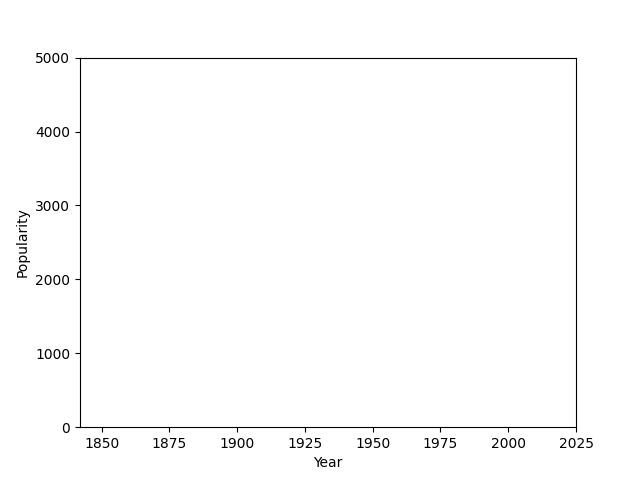

In [10]:
# Animated Line Graph of Composer Frequency over Time

# Setup and Modifiable Variables
uniq_composers = works["composer"].unique()
comp_freq = pd.Series(np.zeros(len(uniq_composers)), index=uniq_composers) # create composer frequency from zero
curr_year = 1842 # start date of animation, first date of concerts
year_range = 5 # modify to adjust for specificity of animation
top_N = 10 # modify to adjust number of composers displayed

# Plot setup
# start with time vs. popularity line graph
fig, ax = plt.subplots()
lines = [ax.plot([], [])[0] for i in range(top_N)]
ax.set(xlim=[1842, 2025], ylim=[0, 5000], xlabel='Year', ylabel='Popularity')
composer_trends = {composer: ([], []) for composer in uniq_composers}

# Group works by their year
works_by_year = works.groupby(works.date.dt.year)

# Function to upate comp_freq with data from specific year_range
def update_freq(composer):
    if composer in comp_freq:
        comp_freq[composer] += 1

# Function to update each frame of the animation
def update(frame):
    global comp_freq, curr_year, year_range, top_N, works_by_year
    # curr_year, curr_year + year_range)
    for year in range(curr_year, curr_year + year_range):
        # Loop through all works in this year and update composer
        if year in works_by_year.groups:
            works_by_year.get_group(year)['composer'].apply(update_freq)

    # Update year for next frame
    curr_year += year_range
    
    # Update line plots... may be disjoint lol BUT not an issue with bar graphs... or lowkey it might still bel ol.
    top = comp_freq.nlargest(top_N)
    i = 0
    for composer, freq in top.items():
        years, freqs = composer_trends[composer]
        years.append(curr_year)
        freqs.append(freq)

        lines[i].set_xdata(years)
        lines[i].set_ydata(freqs)
        lines[i].set_label(composer)
        i += 1
    
    ax.legend(loc='upper left')

    return lines

ani = animation.FuncAnimation(fig=fig, func=update, frames=(2025 - 1842) // year_range, interval=1000, blit=True)
plt.show()